In [5]:
##################################################################################
##### Define all parameters for model tuning
##################################################################################

n_fold = 5
expName = "NT_Site_PredNTS_Classification_DLNN_Kgap"
outPath = "Results"
foldName = "folds.pickle"

epochs = 100
batch_size = 16
shuffle = True
seed = None

input_data_folder = "PredNTS_MathFeature_ENC"

In [54]:
kgap_max = 4

train_data_filename = 'Training-datasets-PredNTS_kgap_{}.csv'
indpe_data_filename = 'independent-dataset-PredNTS_kgap_{}.csv'

corr_cutoff = 0.7

In [7]:
import os 
import pickle
import numpy as np
import pandas as pd

import tensorflow as tf

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, confusion_matrix
from sklearn.metrics import roc_auc_score, classification_report

import math

In [8]:
# print(tf.test.is_gpu_available(cuda_only=True))
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [9]:
# ##################################################################################
# ##### define all CUSTOM functions
# ##################################################################################

# def one_hot_encode_nt(sequence, char_dict):
    
#     seq_encoded = np.zeros((len(sequence),len(char_dict)))
    
#     i = 0
#     for single_character in sequence:
#         if(single_character.upper() in char_dict.keys()):
#             seq_encoded[i][char_dict[single_character.upper()]] = 1
#             i = i+1
#         else:
#             raise ValueError('Incorrect character in NT sequence: '+sequence)
#     return seq_encoded

In [10]:
##################################################################################
##### Build k-fold functions
##################################################################################

## Build the K-fold from dataset
def build_kfold(features, labels, k=10, shuffle=False, seed=None):
    
    skf = StratifiedKFold(n_splits=k, shuffle=shuffle, random_state=seed)
    kfoldList = []
    for train_index, test_index in skf.split(features, labels):
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        kfoldList.append({
            "X_train": X_train,
            "X_test": X_test,
            "y_train":y_train,
            "y_test":y_test
        })
    return kfoldList

In [11]:
##################################################################################
##### define evaluator functions
##################################################################################

def pred2label(y_pred):
    y_pred = np.round(y_pred)
    return y_pred

In [12]:
##################################################################################
##### Function to customize the DLNN architecture with parameters
##################################################################################

def DLNN_Classifier(input_vec_shape,
                    dense_decode_units = 512, ## Dense layer parameters
                    prob = 0.25, learn_rate = 0.001, loss = 'binary_crossentropy', metrics = 'accuracy'):
    
    beta = 0.001
    
    input1 = tf.keras.layers.Input(shape=input_vec_shape)
    
    ######################################################################################################
    ########  Classifier  ################################################################################
    ######################################################################################################
    
    y = tf.keras.layers.Dense(dense_decode_units, 
                              kernel_regularizer = tf.keras.regularizers.l2(beta))(input1)
    
    y = tf.keras.layers.Dropout(prob)(y)
    
    y = tf.keras.layers.Dense(int(dense_decode_units/2), 
                              kernel_regularizer = tf.keras.regularizers.l2(beta), 
                              activation = 'relu')(y)
    
    y = tf.keras.layers.Dropout(prob)(y)
    
    y = tf.keras.layers.Dense(int(dense_decode_units/4), 
                              kernel_regularizer = tf.keras.regularizers.l2(beta), 
                              activation = 'relu')(y)
    
    y = tf.keras.layers.Dropout(prob)(y)
    
    y = tf.keras.layers.Dense(1, 
                              kernel_regularizer = tf.keras.regularizers.l2(beta), 
                              activation = 'sigmoid')(y)

    ## Generate Model from input and output
    model = tf.keras.models.Model(inputs=input1, outputs=y)
    
    ## Compile model
    if(metrics != None):
        model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate), 
                      loss = loss, metrics = metrics)
    else:
        model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate), 
                      loss = loss)

    return model

In [13]:
# for step in range(10):
#     initial_learning_rate=1e-1
#     decay_steps=10000
#     decay_rate=0.9
#     print(step, ':', initial_learning_rate * decay_rate ** (step / decay_steps))

In [15]:
DLNN_Classifier((2000)).summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2000)]            0         
                                                                 
 dense_4 (Dense)             (None, 512)               1024512   
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0   

# Train data preparation

In [28]:
##################################################################################
##### Read CSV data
##################################################################################

for i in range(kgap_max+1):
    
    current_train_data_filepath = os.path.join(input_data_folder, train_data_filename.format(i))
    current_train_data = pd.read_csv(current_train_data_filepath, sep=',', header=0)
    current_train_data = current_train_data.drop('label', axis=1)
    
    if i == 0:
        train_data = current_train_data
    else:
        train_data = pd.merge(
            train_data,
            current_train_data,
            how="inner",
            on='nameseq'
        )

train_data['label'] = pd.Series([int(val.split('_')[-2])
                                 for val in train_data['nameseq']])

train_data = train_data.drop('nameseq', axis=1)

##################################################################################
##### Extract features and labels, create folds
##################################################################################

train_features = np.array(train_data.drop('label', axis=1))
train_labels = np.array(train_data['label'])
train_labels = train_labels.reshape((train_labels.shape[0], 1))

input_vec_shape = train_features[0].shape

folds = build_kfold(train_features, train_labels, k=n_fold, shuffle=shuffle, seed=seed)

## Write the k-fold dataset to file
foldPath = os.path.join(outPath, expName, "{}fold".format(n_fold))
if(not os.path.isdir(foldPath)):
    os.makedirs(foldPath)
pickle.dump(folds, open(os.path.join(foldPath, foldName), "wb"))

Training-datasets-PredNTS_kgap_0.csv
Training-datasets-PredNTS_kgap_1.csv
Training-datasets-PredNTS_kgap_2.csv
Training-datasets-PredNTS_kgap_3.csv
Training-datasets-PredNTS_kgap_4.csv


In [33]:
df_corr = train_data.corr()

In [32]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Correlation Matrix')

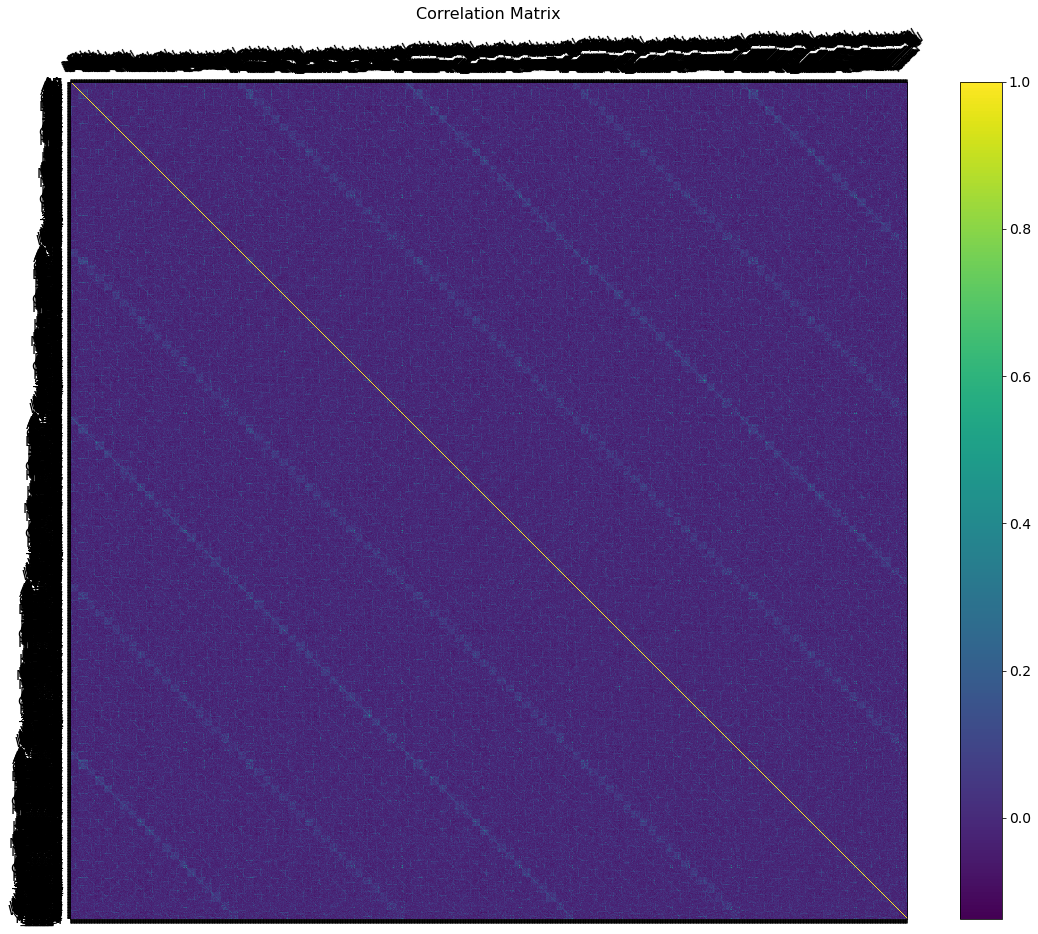

In [35]:
f = plt.figure(figsize=(19, 15))
plt.matshow(df_corr, fignum=f.number)
plt.xticks(range(df_corr.select_dtypes(['number']).shape[1]), df_corr.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df_corr.select_dtypes(['number']).shape[1]), df_corr.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

In [36]:
def matrix_to_xy(df, columns=None, reset_index=False):
    bool_index = np.triu(np.ones(df.shape)).astype(bool)
    xy = (
        df.where(bool_index).stack().reset_index()
        if reset_index
        else df.where(bool_index).stack()
    )
    if reset_index:
        xy.columns = columns or ["row", "col", "val"]
    return xy


def xy_to_matrix(xy):
    df = xy.pivot(*xy.columns).fillna(0)
    df_vals = df.to_numpy()
    df = pd.DataFrame(
        np.triu(df_vals, 1) + df_vals.T, index=df.index, columns=df.index
    )
    return df

In [43]:
df_corr_ = matrix_to_xy(df_corr, reset_index=True)
df_corr_ = df_corr_[df_corr_.row != df_corr_.col]

In [53]:
df_corr_['abs_val'] = abs(df_corr_['val'])

In [57]:
df_potential_drop = df_corr_[df_corr_['abs_val'] >= 0.5]
df_potential_drop

,row,col,val,abs_val
473026,PP,P_P,0.815836,0.815836
473426,PP,P__P,0.726699,0.726699
473826,PP,P___P,0.726402,0.726402
474226,PP,P____P,0.662491,0.662491
581260,SS,S_S,0.517951,0.517951
582060,SS,S___S,0.526904,0.526904
1092826,P_P,P__P,0.749613,0.749613
1093226,P_P,P___P,0.744145,0.744145
1093626,P_P,P____P,0.726663,0.726663
1175860,S_S,S__S,0.503644,0.503644


In [55]:
df_corr_

,row,col,val,abs_val
1,AA,AC,0.030313,0.030313
2,AA,AD,0.028781,0.028781
3,AA,AE,0.046689,0.046689
4,AA,AF,0.025733,0.025733
5,AA,AG,0.076931,0.076931
...,...,...,...,...
2002993,Y____V,Y____Y,-0.055770,0.055770
2002994,Y____V,label,-0.032987,0.032987
2002996,Y____W,Y____Y,-0.028583,0.028583
2002997,Y____W,label,-0.071097,0.071097


# Training

In [12]:
##################################################################################
##### For each input file, train model and generate different outputs in a structured folder
##################################################################################

## create the evaluation data structure for all iterations
evaluations = {
    "Fold" : [],
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

##################################################################################
##### Train/Test model on all folds, generate evaluations
##################################################################################

## Create and set directory to save model
modelPath = os.path.join(outPath, expName, "{}fold".format(n_fold), "models")
if(not os.path.isdir(modelPath)):
    os.makedirs(modelPath)

i = -1
for fold in folds:
    i += 1
    
    print("\nTrain/Test model on Fold #"+str(i)+".")
    
    model = DLNN_Classifier(input_vec_shape = input_vec_shape)
    
    ## Define the model callbacks for early stopping and saving the model. Then train model
    current_model_path = os.path.join(modelPath, "bestModel-fold{}.hdf5".format(i))
    modelCallbacks = [
        tf.keras.callbacks.ModelCheckpoint(current_model_path,
                                           monitor = 'val_loss', verbose = 1, save_best_only = True, 
                                           save_weights_only = False, mode = 'auto', save_freq = 'epoch'),
    ]
    
    # adding random shuffling of the dataset for training purpose
    index_arr = np.arange(fold["X_train"].shape[0])
    index_arr = np.random.permutation(index_arr)
    
    model.fit(x = fold["X_train"][index_arr], y = fold["y_train"][index_arr], batch_size = batch_size, epochs = epochs, verbose = 1, 
              callbacks = modelCallbacks, validation_data = (fold["X_test"], fold["y_test"]))
    
    model = tf.keras.models.load_model(current_model_path)
    
    ##################################################################################
    ##### Prediction and metrics for TRAIN dataset
    ##################################################################################

    y_pred = model.predict(fold["X_train"])
    label_pred = pred2label(y_pred)
    
    # Compute precision, recall, sensitivity, specifity, mcc
    acc = accuracy_score(fold["y_train"], label_pred)
    prec = precision_score(fold["y_train"],label_pred)

    conf = confusion_matrix(fold["y_train"], label_pred)
    if(conf[0][0]+conf[1][0]):
        sens = float(conf[0][0])/float(conf[0][0]+conf[1][0])
    else:
        sens = 0.0
    if(conf[1][1]+conf[0][1]):
        spec = float(conf[1][1])/float(conf[1][1]+conf[0][1])
    else:
        spec = 0.0
    if((conf[0][0]+conf[0][1])*(conf[0][0]+conf[1][0])*(conf[1][1]+conf[0][1])*(conf[1][1]+conf[1][0])):
        mcc = (float(conf[0][0])*float(conf[1][1]) - float(conf[1][0])*float(conf[0][1]))/math.sqrt((conf[0][0]+conf[0][1])*(conf[0][0]+conf[1][0])*(conf[1][1]+conf[0][1])*(conf[1][1]+conf[1][0]))
    else:
        mcc= 0.0
    fpr, tpr, thresholds = roc_curve(fold["y_train"], y_pred)
    auc = roc_auc_score(fold["y_train"], y_pred)
    
    evaluations["Fold"].append(i)
    evaluations["Train_Test"].append("Train")
    evaluations["Accuracy"].append(acc)
    evaluations["Precision"].append(prec)
    evaluations["TPR"].append(tpr)
    evaluations["FPR"].append(fpr)
    evaluations["TPR_FPR_Thresholds"].append(thresholds)
    evaluations["AUC"].append(auc)
    evaluations["Sensitivity"].append(sens)
    evaluations["Specificity"].append(spec)
    evaluations["MCC"].append(mcc)
    
    ##################################################################################
    ##### Prediction and metrics for TEST dataset
    ##################################################################################

    y_pred = model.predict(fold["X_test"])
    label_pred = pred2label(y_pred)
    
    # Compute precision, recall, sensitivity, specifity, mcc
    acc = accuracy_score(fold["y_test"], label_pred)
    prec = precision_score(fold["y_test"],label_pred)

    conf = confusion_matrix(fold["y_test"], label_pred)
    if(conf[0][0]+conf[1][0]):
        sens = float(conf[0][0])/float(conf[0][0]+conf[1][0])
    else:
        sens = 0.0
    if(conf[1][1]+conf[0][1]):
        spec = float(conf[1][1])/float(conf[1][1]+conf[0][1])
    else:
        spec = 0.0
    if((conf[0][0]+conf[0][1])*(conf[0][0]+conf[1][0])*(conf[1][1]+conf[0][1])*(conf[1][1]+conf[1][0])):
        mcc = (float(conf[0][0])*float(conf[1][1]) - float(conf[1][0])*float(conf[0][1]))/math.sqrt((conf[0][0]+conf[0][1])*(conf[0][0]+conf[1][0])*(conf[1][1]+conf[0][1])*(conf[1][1]+conf[1][0]))
    else:
        mcc= 0.0
    fpr, tpr, thresholds = roc_curve(fold["y_test"], y_pred)
    auc = roc_auc_score(fold["y_test"], y_pred)
    
    evaluations["Fold"].append(i)
    evaluations["Train_Test"].append("Test")
    evaluations["Accuracy"].append(acc)
    evaluations["Precision"].append(prec)
    evaluations["TPR"].append(tpr)
    evaluations["FPR"].append(fpr)
    evaluations["TPR_FPR_Thresholds"].append(thresholds)
    evaluations["AUC"].append(auc)
    evaluations["Sensitivity"].append(sens)
    evaluations["Specificity"].append(spec)
    evaluations["MCC"].append(mcc)


Train/Test model on Fold #0.
Epoch 1/100
115/120 [===========================>..] - ETA: 0s - loss: 0.9094 - accuracy: 0.6174
Epoch 1: val_loss improved from inf to 0.69904, saving model to Results\NT_Site_PredNTS_Classification_DLNN_Kmer\5fold\models\bestModel-fold0.hdf5
120/120 [==============================] - 2s 9ms/step - loss: 0.9034 - accuracy: 0.6210 - val_loss: 0.6990 - val_accuracy: 0.7547
Epoch 2/100
112/120 [===========================>..] - ETA: 0s - loss: 0.6660 - accuracy: 0.7818
Epoch 2: val_loss did not improve from 0.69904
120/120 [==============================] - 1s 5ms/step - loss: 0.6720 - accuracy: 0.7759 - val_loss: 0.7302 - val_accuracy: 0.7275
Epoch 3/100
114/120 [===========================>..] - ETA: 0s - loss: 0.6011 - accuracy: 0.8388
Epoch 3: val_loss did not improve from 0.69904
120/120 [==============================] - 1s 5ms/step - loss: 0.6066 - accuracy: 0.8367 - val_loss: 0.7009 - val_accuracy: 0.7925
Epoch 4/100
114/120 [========================

Epoch 60/100
113/120 [===========================>..] - ETA: 0s - loss: 0.2143 - accuracy: 0.9873
Epoch 60: val_loss did not improve from 0.69904
120/120 [==============================] - 1s 5ms/step - loss: 0.2199 - accuracy: 0.9869 - val_loss: 0.8728 - val_accuracy: 0.7631
Epoch 61/100
113/120 [===========================>..] - ETA: 0s - loss: 0.2055 - accuracy: 0.9912
Epoch 61: val_loss did not improve from 0.69904
120/120 [==============================] - 1s 5ms/step - loss: 0.2060 - accuracy: 0.9911 - val_loss: 0.7508 - val_accuracy: 0.8092
Epoch 62/100
112/120 [===========================>..] - ETA: 0s - loss: 0.2131 - accuracy: 0.9905
Epoch 62: val_loss did not improve from 0.69904
120/120 [==============================] - 1s 5ms/step - loss: 0.2129 - accuracy: 0.9900 - val_loss: 0.8012 - val_accuracy: 0.8071
Epoch 63/100
112/120 [===========================>..] - ETA: 0s - loss: 0.2200 - accuracy: 0.9883
Epoch 63: val_loss did not improve from 0.69904
120/120 [==============

Epoch 90/100
120/120 [==============================] - ETA: 0s - loss: 0.2260 - accuracy: 0.9885
Epoch 90: val_loss did not improve from 0.69904
120/120 [==============================] - 1s 5ms/step - loss: 0.2260 - accuracy: 0.9885 - val_loss: 0.8332 - val_accuracy: 0.7757
Epoch 91/100
111/120 [==========================>...] - ETA: 0s - loss: 0.2286 - accuracy: 0.9887
Epoch 91: val_loss did not improve from 0.69904
120/120 [==============================] - 1s 5ms/step - loss: 0.2281 - accuracy: 0.9890 - val_loss: 0.8317 - val_accuracy: 0.7694
Epoch 92/100
110/120 [==========================>...] - ETA: 0s - loss: 0.2230 - accuracy: 0.9898
Epoch 92: val_loss did not improve from 0.69904
120/120 [==============================] - 1s 5ms/step - loss: 0.2264 - accuracy: 0.9885 - val_loss: 0.8125 - val_accuracy: 0.8029
Epoch 93/100
109/120 [==========================>...] - ETA: 0s - loss: 0.2331 - accuracy: 0.9874
Epoch 93: val_loss did not improve from 0.69904
120/120 [==============

120/120 [==============================] - 1s 5ms/step - loss: 0.2786 - accuracy: 0.9785 - val_loss: 0.9062 - val_accuracy: 0.7589
Epoch 19/100
110/120 [==========================>...] - ETA: 0s - loss: 0.2701 - accuracy: 0.9801
Epoch 19: val_loss did not improve from 0.74383
120/120 [==============================] - 1s 5ms/step - loss: 0.2738 - accuracy: 0.9790 - val_loss: 0.9318 - val_accuracy: 0.7505
Epoch 20/100
109/120 [==========================>...] - ETA: 0s - loss: 0.2685 - accuracy: 0.9805
Epoch 20: val_loss did not improve from 0.74383
120/120 [==============================] - 1s 5ms/step - loss: 0.2675 - accuracy: 0.9811 - val_loss: 0.8747 - val_accuracy: 0.7862
Epoch 21/100
109/120 [==========================>...] - ETA: 0s - loss: 0.2589 - accuracy: 0.9834
Epoch 21: val_loss did not improve from 0.74383
120/120 [==============================] - 1s 5ms/step - loss: 0.2616 - accuracy: 0.9827 - val_loss: 0.8477 - val_accuracy: 0.7820
Epoch 22/100
109/120 [================

Epoch 78/100
120/120 [==============================] - ETA: 0s - loss: 0.2078 - accuracy: 0.9890
Epoch 78: val_loss did not improve from 0.74383
120/120 [==============================] - 1s 5ms/step - loss: 0.2078 - accuracy: 0.9890 - val_loss: 0.7858 - val_accuracy: 0.7862
Epoch 79/100
109/120 [==========================>...] - ETA: 0s - loss: 0.2127 - accuracy: 0.9885
Epoch 79: val_loss did not improve from 0.74383
120/120 [==============================] - 1s 5ms/step - loss: 0.2171 - accuracy: 0.9858 - val_loss: 0.8590 - val_accuracy: 0.7862
Epoch 80/100
110/120 [==========================>...] - ETA: 0s - loss: 0.2230 - accuracy: 0.9920
Epoch 80: val_loss did not improve from 0.74383
120/120 [==============================] - 1s 5ms/step - loss: 0.2249 - accuracy: 0.9906 - val_loss: 0.8733 - val_accuracy: 0.7862
Epoch 81/100
118/120 [============================>.] - ETA: 0s - loss: 0.2094 - accuracy: 0.9905
Epoch 81: val_loss did not improve from 0.74383
120/120 [==============

Epoch 37/100
109/120 [==========================>...] - ETA: 0s - loss: 0.2461 - accuracy: 0.9857
Epoch 37: val_loss did not improve from 0.70427
120/120 [==============================] - 1s 5ms/step - loss: 0.2486 - accuracy: 0.9853 - val_loss: 0.8916 - val_accuracy: 0.7836
Epoch 38/100
109/120 [==========================>...] - ETA: 0s - loss: 0.2554 - accuracy: 0.9828
Epoch 38: val_loss did not improve from 0.70427
120/120 [==============================] - 1s 5ms/step - loss: 0.2543 - accuracy: 0.9832 - val_loss: 0.8424 - val_accuracy: 0.7878
Epoch 39/100
120/120 [==============================] - ETA: 0s - loss: 0.2322 - accuracy: 0.9879
Epoch 39: val_loss did not improve from 0.70427
120/120 [==============================] - 1s 5ms/step - loss: 0.2322 - accuracy: 0.9879 - val_loss: 0.8267 - val_accuracy: 0.7878
Epoch 40/100
118/120 [============================>.] - ETA: 0s - loss: 0.2200 - accuracy: 0.9905
Epoch 40: val_loss did not improve from 0.70427
120/120 [==============

Epoch 67/100
120/120 [==============================] - ETA: 0s - loss: 0.2025 - accuracy: 0.9921
Epoch 67: val_loss did not improve from 0.70427
120/120 [==============================] - 1s 5ms/step - loss: 0.2025 - accuracy: 0.9921 - val_loss: 0.8324 - val_accuracy: 0.7878
Epoch 68/100
117/120 [============================>.] - ETA: 0s - loss: 0.2224 - accuracy: 0.9866
Epoch 68: val_loss did not improve from 0.70427
120/120 [==============================] - 1s 5ms/step - loss: 0.2223 - accuracy: 0.9869 - val_loss: 0.8984 - val_accuracy: 0.7752
Epoch 69/100
109/120 [==========================>...] - ETA: 0s - loss: 0.2262 - accuracy: 0.9874
Epoch 69: val_loss did not improve from 0.70427
120/120 [==============================] - 1s 5ms/step - loss: 0.2313 - accuracy: 0.9858 - val_loss: 0.8660 - val_accuracy: 0.7815
Epoch 70/100
110/120 [==========================>...] - ETA: 0s - loss: 0.2263 - accuracy: 0.9898
Epoch 70: val_loss did not improve from 0.70427
120/120 [==============

Epoch 97/100
118/120 [============================>.] - ETA: 0s - loss: 0.2282 - accuracy: 0.9868
Epoch 97: val_loss did not improve from 0.70427
120/120 [==============================] - 1s 5ms/step - loss: 0.2278 - accuracy: 0.9869 - val_loss: 0.8719 - val_accuracy: 0.7752
Epoch 98/100
120/120 [==============================] - ETA: 0s - loss: 0.2111 - accuracy: 0.9895
Epoch 98: val_loss did not improve from 0.70427
120/120 [==============================] - 1s 5ms/step - loss: 0.2111 - accuracy: 0.9895 - val_loss: 0.8701 - val_accuracy: 0.7878
Epoch 99/100
120/120 [==============================] - ETA: 0s - loss: 0.2166 - accuracy: 0.9900
Epoch 99: val_loss did not improve from 0.70427
120/120 [==============================] - 1s 5ms/step - loss: 0.2166 - accuracy: 0.9900 - val_loss: 0.8739 - val_accuracy: 0.7899
Epoch 100/100
110/120 [==========================>...] - ETA: 0s - loss: 0.2117 - accuracy: 0.9881
Epoch 100: val_loss did not improve from 0.70427
120/120 [============

Epoch 26/100
117/120 [============================>.] - ETA: 0s - loss: 0.2337 - accuracy: 0.9899
Epoch 26: val_loss did not improve from 0.65533
120/120 [==============================] - 1s 5ms/step - loss: 0.2343 - accuracy: 0.9895 - val_loss: 0.8175 - val_accuracy: 0.8046
Epoch 27/100
117/120 [============================>.] - ETA: 0s - loss: 0.2309 - accuracy: 0.9866
Epoch 27: val_loss did not improve from 0.65533
120/120 [==============================] - 1s 5ms/step - loss: 0.2303 - accuracy: 0.9869 - val_loss: 0.8164 - val_accuracy: 0.7899
Epoch 28/100
117/120 [============================>.] - ETA: 0s - loss: 0.2439 - accuracy: 0.9829
Epoch 28: val_loss did not improve from 0.65533
120/120 [==============================] - 1s 5ms/step - loss: 0.2461 - accuracy: 0.9816 - val_loss: 0.9139 - val_accuracy: 0.7605
Epoch 29/100
120/120 [==============================] - ETA: 0s - loss: 0.2705 - accuracy: 0.9780
Epoch 29: val_loss did not improve from 0.65533
120/120 [==============

Epoch 56/100
116/120 [============================>.] - ETA: 0s - loss: 0.2374 - accuracy: 0.9855
Epoch 56: val_loss did not improve from 0.65533
120/120 [==============================] - 1s 5ms/step - loss: 0.2390 - accuracy: 0.9848 - val_loss: 0.9495 - val_accuracy: 0.7752
Epoch 57/100
109/120 [==========================>...] - ETA: 0s - loss: 0.2393 - accuracy: 0.9874
Epoch 57: val_loss did not improve from 0.65533
120/120 [==============================] - 1s 5ms/step - loss: 0.2388 - accuracy: 0.9874 - val_loss: 0.7930 - val_accuracy: 0.8046
Epoch 58/100
120/120 [==============================] - ETA: 0s - loss: 0.2172 - accuracy: 0.9906
Epoch 58: val_loss did not improve from 0.65533
120/120 [==============================] - 1s 5ms/step - loss: 0.2172 - accuracy: 0.9906 - val_loss: 0.8465 - val_accuracy: 0.7983
Epoch 59/100
109/120 [==========================>...] - ETA: 0s - loss: 0.1991 - accuracy: 0.9937
Epoch 59: val_loss did not improve from 0.65533
120/120 [==============

Epoch 86/100
120/120 [==============================] - ETA: 0s - loss: 0.2337 - accuracy: 0.9874
Epoch 86: val_loss did not improve from 0.65533
120/120 [==============================] - 1s 6ms/step - loss: 0.2337 - accuracy: 0.9874 - val_loss: 0.8194 - val_accuracy: 0.8067
Epoch 87/100
110/120 [==========================>...] - ETA: 0s - loss: 0.2162 - accuracy: 0.9909
Epoch 87: val_loss did not improve from 0.65533
120/120 [==============================] - 1s 6ms/step - loss: 0.2160 - accuracy: 0.9906 - val_loss: 0.7824 - val_accuracy: 0.8025
Epoch 88/100
119/120 [============================>.] - ETA: 0s - loss: 0.2068 - accuracy: 0.9926
Epoch 88: val_loss did not improve from 0.65533
120/120 [==============================] - 1s 6ms/step - loss: 0.2068 - accuracy: 0.9927 - val_loss: 0.8490 - val_accuracy: 0.8088
Epoch 89/100
111/120 [==========================>...] - ETA: 0s - loss: 0.1938 - accuracy: 0.9955
Epoch 89: val_loss did not improve from 0.65533
120/120 [==============

Epoch 15/100
120/120 [==============================] - ETA: 0s - loss: 0.2853 - accuracy: 0.9738
Epoch 15: val_loss did not improve from 0.65684
120/120 [==============================] - 1s 6ms/step - loss: 0.2853 - accuracy: 0.9738 - val_loss: 0.8284 - val_accuracy: 0.7920
Epoch 16/100
117/120 [============================>.] - ETA: 0s - loss: 0.2891 - accuracy: 0.9760
Epoch 16: val_loss did not improve from 0.65684
120/120 [==============================] - 1s 5ms/step - loss: 0.2891 - accuracy: 0.9759 - val_loss: 0.8227 - val_accuracy: 0.7983
Epoch 17/100
119/120 [============================>.] - ETA: 0s - loss: 0.2959 - accuracy: 0.9701
Epoch 17: val_loss did not improve from 0.65684
120/120 [==============================] - 1s 6ms/step - loss: 0.2959 - accuracy: 0.9701 - val_loss: 0.8591 - val_accuracy: 0.7731
Epoch 18/100
113/120 [===========================>..] - ETA: 0s - loss: 0.2947 - accuracy: 0.9773
Epoch 18: val_loss did not improve from 0.65684
120/120 [==============

Epoch 45/100
119/120 [============================>.] - ETA: 0s - loss: 0.2369 - accuracy: 0.9863
Epoch 45: val_loss did not improve from 0.65684
120/120 [==============================] - 1s 6ms/step - loss: 0.2369 - accuracy: 0.9864 - val_loss: 0.9513 - val_accuracy: 0.7773
Epoch 46/100
118/120 [============================>.] - ETA: 0s - loss: 0.2378 - accuracy: 0.9857
Epoch 46: val_loss did not improve from 0.65684
120/120 [==============================] - 1s 6ms/step - loss: 0.2377 - accuracy: 0.9858 - val_loss: 0.8231 - val_accuracy: 0.7962
Epoch 47/100
113/120 [===========================>..] - ETA: 0s - loss: 0.2319 - accuracy: 0.9856
Epoch 47: val_loss did not improve from 0.65684
120/120 [==============================] - 1s 6ms/step - loss: 0.2348 - accuracy: 0.9858 - val_loss: 0.8208 - val_accuracy: 0.8046
Epoch 48/100
110/120 [==========================>...] - ETA: 0s - loss: 0.2136 - accuracy: 0.9892
Epoch 48: val_loss did not improve from 0.65684
120/120 [==============

Epoch 75/100
116/120 [============================>.] - ETA: 0s - loss: 0.2326 - accuracy: 0.9865
Epoch 75: val_loss did not improve from 0.65684
120/120 [==============================] - 1s 5ms/step - loss: 0.2324 - accuracy: 0.9869 - val_loss: 0.8614 - val_accuracy: 0.7920
Epoch 76/100
119/120 [============================>.] - ETA: 0s - loss: 0.2219 - accuracy: 0.9890
Epoch 76: val_loss did not improve from 0.65684
120/120 [==============================] - 1s 5ms/step - loss: 0.2219 - accuracy: 0.9890 - val_loss: 0.8472 - val_accuracy: 0.7836
Epoch 77/100
119/120 [============================>.] - ETA: 0s - loss: 0.2180 - accuracy: 0.9863
Epoch 77: val_loss did not improve from 0.65684
120/120 [==============================] - 1s 5ms/step - loss: 0.2180 - accuracy: 0.9864 - val_loss: 0.8246 - val_accuracy: 0.7899
Epoch 78/100
117/120 [============================>.] - ETA: 0s - loss: 0.2120 - accuracy: 0.9909
Epoch 78: val_loss did not improve from 0.65684
120/120 [==============

## k-fold Training evaluation

In [13]:
evaluations_df = pd.DataFrame.from_dict(evaluations)

evaluations_df_grouped = evaluations_df.groupby(["Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

evaluations_df_grouped

,Accuracy,Precision,AUC,Sensitivity,Specificity,MCC
Train_Test,,,,,,
Test,0.774142,0.792824,0.841165,0.766253,0.792824,0.553688
Train,0.867550,0.890778,0.927854,0.850559,0.890778,0.738187


# Independent data

In [14]:
##################################################################################
##### Read CSV data
##################################################################################

indpe_data_filepath = os.path.join(input_data_folder, indpe_data_filename)
indpe_data = pd.read_csv(indpe_data_filepath, sep=',', header=0)
indpe_data = indpe_data.drop('label', axis=1)

indpe_data['label'] = pd.Series([int(val.split('_')[-2])
                                 for val in indpe_data['nameseq']])

indpe_data = indpe_data.drop('nameseq', axis=1)

##################################################################################
##### Extract features and labels, create folds
##################################################################################

indpe_features = np.array(indpe_data.drop('label', axis=1))
indpe_labels = np.array(indpe_data['label'])
indpe_labels = indpe_labels.reshape((indpe_labels.shape[0], 1))

## Using k-fold Models

### Performance of each k-fold model

In [15]:
## create the evaluation data structure for all iterations
evaluations = {
    "Fold" : [],
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

##################################################################################
##### Prediction and metrics for Independent dataset
##################################################################################

for i in range(n_fold):
    
    current_model_path = os.path.join(modelPath, "bestModel-fold{}.hdf5".format(i))
    model = tf.keras.models.load_model(current_model_path)

    y_pred = model.predict(indpe_features)
    label_pred = pred2label(y_pred)

    # Compute precision, recall, sensitivity, specifity, mcc
    acc = accuracy_score(indpe_labels, label_pred)
    prec = precision_score(indpe_labels,label_pred)

    conf = confusion_matrix(indpe_labels, label_pred)
    if(conf[0][0]+conf[1][0]):
        sens = float(conf[0][0])/float(conf[0][0]+conf[1][0])
    else:
        sens = 0.0
    if(conf[1][1]+conf[0][1]):
        spec = float(conf[1][1])/float(conf[1][1]+conf[0][1])
    else:
        spec = 0.0
    if((conf[0][0]+conf[0][1])*(conf[0][0]+conf[1][0])*(conf[1][1]+conf[0][1])*(conf[1][1]+conf[1][0])):
        mcc = (float(conf[0][0])*float(conf[1][1]) - float(conf[1][0])*float(conf[0][1]))/math.sqrt((conf[0][0]+conf[0][1])*(conf[0][0]+conf[1][0])*(conf[1][1]+conf[0][1])*(conf[1][1]+conf[1][0]))
    else:
        mcc= 0.0
    fpr, tpr, thresholds = roc_curve(indpe_labels, y_pred)
    auc = roc_auc_score(indpe_labels, y_pred)

    evaluations["Fold"].append(i)
    evaluations["Train_Test"].append("Independent")
    evaluations["Accuracy"].append(acc)
    evaluations["Precision"].append(prec)
    evaluations["TPR"].append(tpr)
    evaluations["FPR"].append(fpr)
    evaluations["TPR_FPR_Thresholds"].append(thresholds)
    evaluations["AUC"].append(auc)
    evaluations["Sensitivity"].append(sens)
    evaluations["Specificity"].append(spec)
    evaluations["MCC"].append(mcc)

##################################################################################

evaluations_df = pd.DataFrame.from_dict(evaluations)

evaluations_df_grouped = evaluations_df.groupby(["Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

evaluations_df_grouped

,Accuracy,Precision,AUC,Sensitivity,Specificity,MCC
Train_Test,,,,,,
Independent,0.620898,0.244637,0.652892,0.889887,0.244637,0.176668


In [16]:
evaluations_df

,Fold,Train_Test,Accuracy,Precision,TPR,FPR,TPR_FPR_Thresholds,AUC,Sensitivity,Specificity,MCC
0,0,Independent,0.675918,0.262255,"[0.0, 0.0, 0.019704433497536946, 0.01970443349...","[0.0, 0.0009784735812133072, 0.000978473581213...","[1.953768, 0.953768, 0.917954, 0.9098915, 0.90...",0.643527,0.882497,0.262255,0.183481
1,1,Independent,0.579592,0.233788,"[0.0, 0.0049261083743842365, 0.004926108374384...","[0.0, 0.0, 0.0009784735812133072, 0.0009784735...","[1.9933343, 0.9933343, 0.9922462, 0.984928, 0....",0.657674,0.896714,0.233788,0.175325
2,2,Independent,0.578776,0.234295,"[0.0, 0.0049261083743842365, 0.004926108374384...","[0.0, 0.0, 0.0009784735812133072, 0.0009784735...","[1.9770317, 0.97703165, 0.9594395, 0.9524515, ...",0.652921,0.897799,0.234295,0.177499
3,3,Independent,0.659592,0.252315,"[0.0, 0.0, 0.019704433497536946, 0.01970443349...","[0.0, 0.0009784735812133072, 0.000978473581213...","[1.9716322, 0.9716323, 0.95402575, 0.90907717,...",0.651181,0.881463,0.252315,0.171905
4,4,Independent,0.610612,0.240530,"[0.0, 0.0049261083743842365, 0.014778325123152...","[0.0, 0.0, 0.0, 0.0009784735812133072, 0.00097...","[1.981107, 0.981107, 0.9755868, 0.97556496, 0....",0.659154,0.890961,0.240530,0.175129


### Mean score with k-fold models

In [17]:
## create the evaluation data structure for all iterations
evaluations = {
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

##################################################################################
##### Prediction and metrics for Independent dataset
##################################################################################

total_pred = np.zeros(indpe_labels.shape)
all_preds = []

for i in range(n_fold):
    
    current_model_path = os.path.join(modelPath, "bestModel-fold{}.hdf5".format(i))
    model = tf.keras.models.load_model(current_model_path)

    y_pred = model.predict(indpe_features)
    total_pred += y_pred
    all_preds.append(y_pred)
    
total_pred = total_pred / n_fold
label_pred = pred2label(total_pred)

# Compute precision, recall, sensitivity, specifity, mcc
acc = accuracy_score(indpe_labels, label_pred)
prec = precision_score(indpe_labels,label_pred)

conf = confusion_matrix(indpe_labels, label_pred)
if(conf[0][0]+conf[1][0]):
    sens = float(conf[0][0])/float(conf[0][0]+conf[1][0])
else:
    sens = 0.0
if(conf[1][1]+conf[0][1]):
    spec = float(conf[1][1])/float(conf[1][1]+conf[0][1])
else:
    spec = 0.0
if((conf[0][0]+conf[0][1])*(conf[0][0]+conf[1][0])*(conf[1][1]+conf[0][1])*(conf[1][1]+conf[1][0])):
    mcc = (float(conf[0][0])*float(conf[1][1]) - float(conf[1][0])*float(conf[0][1]))/math.sqrt((conf[0][0]+conf[0][1])*(conf[0][0]+conf[1][0])*(conf[1][1]+conf[0][1])*(conf[1][1]+conf[1][0]))
else:
    mcc= 0.0
fpr, tpr, thresholds = roc_curve(indpe_labels, total_pred)
auc = roc_auc_score(indpe_labels, total_pred)

evaluations["Train_Test"].append("Independent")
evaluations["Accuracy"].append(acc)
evaluations["Precision"].append(prec)
evaluations["TPR"].append(tpr)
evaluations["FPR"].append(fpr)
evaluations["TPR_FPR_Thresholds"].append(thresholds)
evaluations["AUC"].append(auc)
evaluations["Sensitivity"].append(sens)
evaluations["Specificity"].append(spec)
evaluations["MCC"].append(mcc)

##################################################################################

evaluations_df = pd.DataFrame.from_dict(evaluations)

evaluations_df_grouped = evaluations_df.groupby(["Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

evaluations_df_grouped

,Accuracy,Precision,AUC,Sensitivity,Specificity,MCC
Train_Test,,,,,,
Independent,0.623673,0.244048,0.6634,0.889043,0.244048,0.17614


### Voting score with k-fold models

In [18]:
## create the evaluation data structure for all iterations
evaluations = {
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

##################################################################################
##### Prediction and metrics for Independent dataset
##################################################################################

total_pred = np.zeros(indpe_labels.shape)
all_preds = []

for i in range(n_fold):
    
    current_model_path = os.path.join(modelPath, "bestModel-fold{}.hdf5".format(i))
    model = tf.keras.models.load_model(current_model_path)

    y_pred = model.predict(indpe_features)
    vote_pred = pred2label(y_pred)
    total_pred += vote_pred
    all_preds.append(vote_pred)
    
total_pred = total_pred / n_fold
label_pred = pred2label(total_pred)

# Compute precision, recall, sensitivity, specifity, mcc
acc = accuracy_score(indpe_labels, label_pred)
prec = precision_score(indpe_labels,label_pred)

conf = confusion_matrix(indpe_labels, label_pred)
if(conf[0][0]+conf[1][0]):
    sens = float(conf[0][0])/float(conf[0][0]+conf[1][0])
else:
    sens = 0.0
if(conf[1][1]+conf[0][1]):
    spec = float(conf[1][1])/float(conf[1][1]+conf[0][1])
else:
    spec = 0.0
if((conf[0][0]+conf[0][1])*(conf[0][0]+conf[1][0])*(conf[1][1]+conf[0][1])*(conf[1][1]+conf[1][0])):
    mcc = (float(conf[0][0])*float(conf[1][1]) - float(conf[1][0])*float(conf[0][1]))/math.sqrt((conf[0][0]+conf[0][1])*(conf[0][0]+conf[1][0])*(conf[1][1]+conf[0][1])*(conf[1][1]+conf[1][0]))
else:
    mcc= 0.0
fpr, tpr, thresholds = roc_curve(indpe_labels, total_pred)
auc = roc_auc_score(indpe_labels, total_pred)

evaluations["Train_Test"].append("Independent")
evaluations["Accuracy"].append(acc)
evaluations["Precision"].append(prec)
evaluations["TPR"].append(tpr)
evaluations["FPR"].append(fpr)
evaluations["TPR_FPR_Thresholds"].append(thresholds)
evaluations["AUC"].append(auc)
evaluations["Sensitivity"].append(sens)
evaluations["Specificity"].append(spec)
evaluations["MCC"].append(mcc)

##################################################################################

evaluations_df = pd.DataFrame.from_dict(evaluations)

evaluations_df_grouped = evaluations_df.groupby(["Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

evaluations_df_grouped

,Accuracy,Precision,AUC,Sensitivity,Specificity,MCC
Train_Test,,,,,,
Independent,0.63102,0.244353,0.660171,0.886179,0.244353,0.171805


## Using New Model

Train model on full data from training. Predict and evaluate on Independent data.

In [ ]:
model = DLNN_Classifier(input_vec_shape = input_vec_shape)
    
## Define the model callbacks for early stopping and saving the model. Then train model
current_model_path = os.path.join(modelPath, "_fullModel.hdf5")
modelCallbacks = [
    tf.keras.callbacks.ModelCheckpoint(current_model_path,
                                       monitor = 'val_loss', verbose = 1, save_best_only = True, 
                                       save_weights_only = False, mode = 'auto', save_freq = 'epoch'),
]

# adding random shuffling of the dataset for training purpose
index_arr = np.arange(train_features.shape[0])
index_arr = np.random.permutation(index_arr)

model.fit(x = train_features[index_arr], y = train_labels[index_arr], batch_size = batch_size, epochs = epochs, verbose = 1, 
          callbacks = modelCallbacks, validation_data = (indpe_features, indpe_labels))
# model.fit(x = train_features[index_arr], y = train_labels[index_arr], batch_size = batch_size, epochs = epochs, verbose = 1, 
#           callbacks = modelCallbacks, validation_split = 0.2)

model = tf.keras.models.load_model(current_model_path)

Epoch 1/100
143/149 [===========================>..] - ETA: 0s - loss: 0.8682 - accuracy: 0.6547
Epoch 1: val_loss improved from inf to 0.77737, saving model to Results\NT_Site_PredNTS_Classification_DLNN_Kmer\5fold\models\_fullModel.hdf5
149/149 [==============================] - 2s 9ms/step - loss: 0.8667 - accuracy: 0.6528 - val_loss: 0.7774 - val_accuracy: 0.6980
Epoch 2/100
146/149 [============================>.] - ETA: 0s - loss: 0.6524 - accuracy: 0.8009
Epoch 2: val_loss did not improve from 0.77737
149/149 [==============================] - 1s 5ms/step - loss: 0.6545 - accuracy: 0.7993 - val_loss: 0.9002 - val_accuracy: 0.6376
Epoch 3/100
143/149 [===========================>..] - ETA: 0s - loss: 0.6254 - accuracy: 0.8287
Epoch 3: val_loss did not improve from 0.77737
149/149 [==============================] - 1s 5ms/step - loss: 0.6287 - accuracy: 0.8262 - val_loss: 0.9462 - val_accuracy: 0.6278
Epoch 4/100
148/149 [============================>.] - ETA: 0s - loss: 0.6029 - 

In [ ]:
## create the evaluation data structure for all iterations
evaluations = {
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

##################################################################################
##### Prediction and metrics for Independent dataset
##################################################################################

y_pred = model.predict(indpe_features)
label_pred = pred2label(y_pred)

# Compute precision, recall, sensitivity, specifity, mcc
acc = accuracy_score(indpe_labels, label_pred)
prec = precision_score(indpe_labels,label_pred)

conf = confusion_matrix(indpe_labels, label_pred)
if(conf[0][0]+conf[1][0]):
    sens = float(conf[0][0])/float(conf[0][0]+conf[1][0])
else:
    sens = 0.0
if(conf[1][1]+conf[0][1]):
    spec = float(conf[1][1])/float(conf[1][1]+conf[0][1])
else:
    spec = 0.0
if((conf[0][0]+conf[0][1])*(conf[0][0]+conf[1][0])*(conf[1][1]+conf[0][1])*(conf[1][1]+conf[1][0])):
    mcc = (float(conf[0][0])*float(conf[1][1]) - float(conf[1][0])*float(conf[0][1]))/math.sqrt((conf[0][0]+conf[0][1])*(conf[0][0]+conf[1][0])*(conf[1][1]+conf[0][1])*(conf[1][1]+conf[1][0]))
else:
    mcc= 0.0
fpr, tpr, thresholds = roc_curve(indpe_labels, y_pred)
auc = roc_auc_score(indpe_labels, y_pred)

evaluations["Train_Test"].append("Independent")
evaluations["Accuracy"].append(acc)
evaluations["Precision"].append(prec)
evaluations["TPR"].append(tpr)
evaluations["FPR"].append(fpr)
evaluations["TPR_FPR_Thresholds"].append(thresholds)
evaluations["AUC"].append(auc)
evaluations["Sensitivity"].append(sens)
evaluations["Specificity"].append(spec)
evaluations["MCC"].append(mcc)

##################################################################################

evaluations_df = pd.DataFrame.from_dict(evaluations)

evaluations_df_grouped = evaluations_df.groupby(["Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

evaluations_df_grouped

In [ ]:
print(classification_report(indpe_labels, np.round(y_pred).astype(int)))